# Explain

I will use Shap to explain original and adversarial images all across this project. In order to do the explanation using shap we need to run tensorflow in lazy execution mode which was the default for Tensorflow 1.0 but is not in 2.0 anymore. Disabling Eager Execution needs to run early after starting the python runtime and cannot be reverted. I.E. that SHAP explanations need to run in its own jupyter notebook.

In [1]:
import shap
import tensorflow as tf
from keras.models import load_model
from numpy import argmax
from pandas import concat, DataFrame

from data.file import model_convolutional_dataset, shap_original_label
from data.file import shap_original, shap_original_missmatches
from data.load import load_test_dataset
from reporting.evaluation import plot_shap, first_occurence
from reporting.images import display_dataframe

In [2]:
print("SHAP version is      :", shap.__version__)
print("Tensorflow version is:", tf.__version__)

tf.compat.v1.disable_eager_execution()

SHAP version is      : 0.40.0
Tensorflow version is: 2.6.2


## Load Test Data, Model

In [3]:
x_test, y_test = load_test_dataset(normalize=True)
model = load_model(model_convolutional_dataset)

## Predictions

In [4]:
compare_items = 10000
prediction = [argmax(x) for x in model.predict(x_test[:compare_items])]
expectation = y_test[:compare_items]

comparison = concat([expectation.rename('actual'), DataFrame(prediction, columns=['prediction'])], axis=1)
comparison_missmatch = comparison[comparison.prediction != comparison.actual]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [5]:
comparison_missmatch = comparison.iloc[comparison_missmatch.index]
labels = comparison_missmatch.prediction.map(str) + " (" + comparison_missmatch.actual.map(str) + ")"

In [6]:
missmatches = x_test[comparison_missmatch.index]

### Display missmatches
Out of 10'000 predictions (amount of test images) we should get roughly between 100 and 200 misspredicted images. This assumption is made out of the recall we got during [model evaluation](./01_confusion_matrix.ipynb). The following table shows all misspredicted items.

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


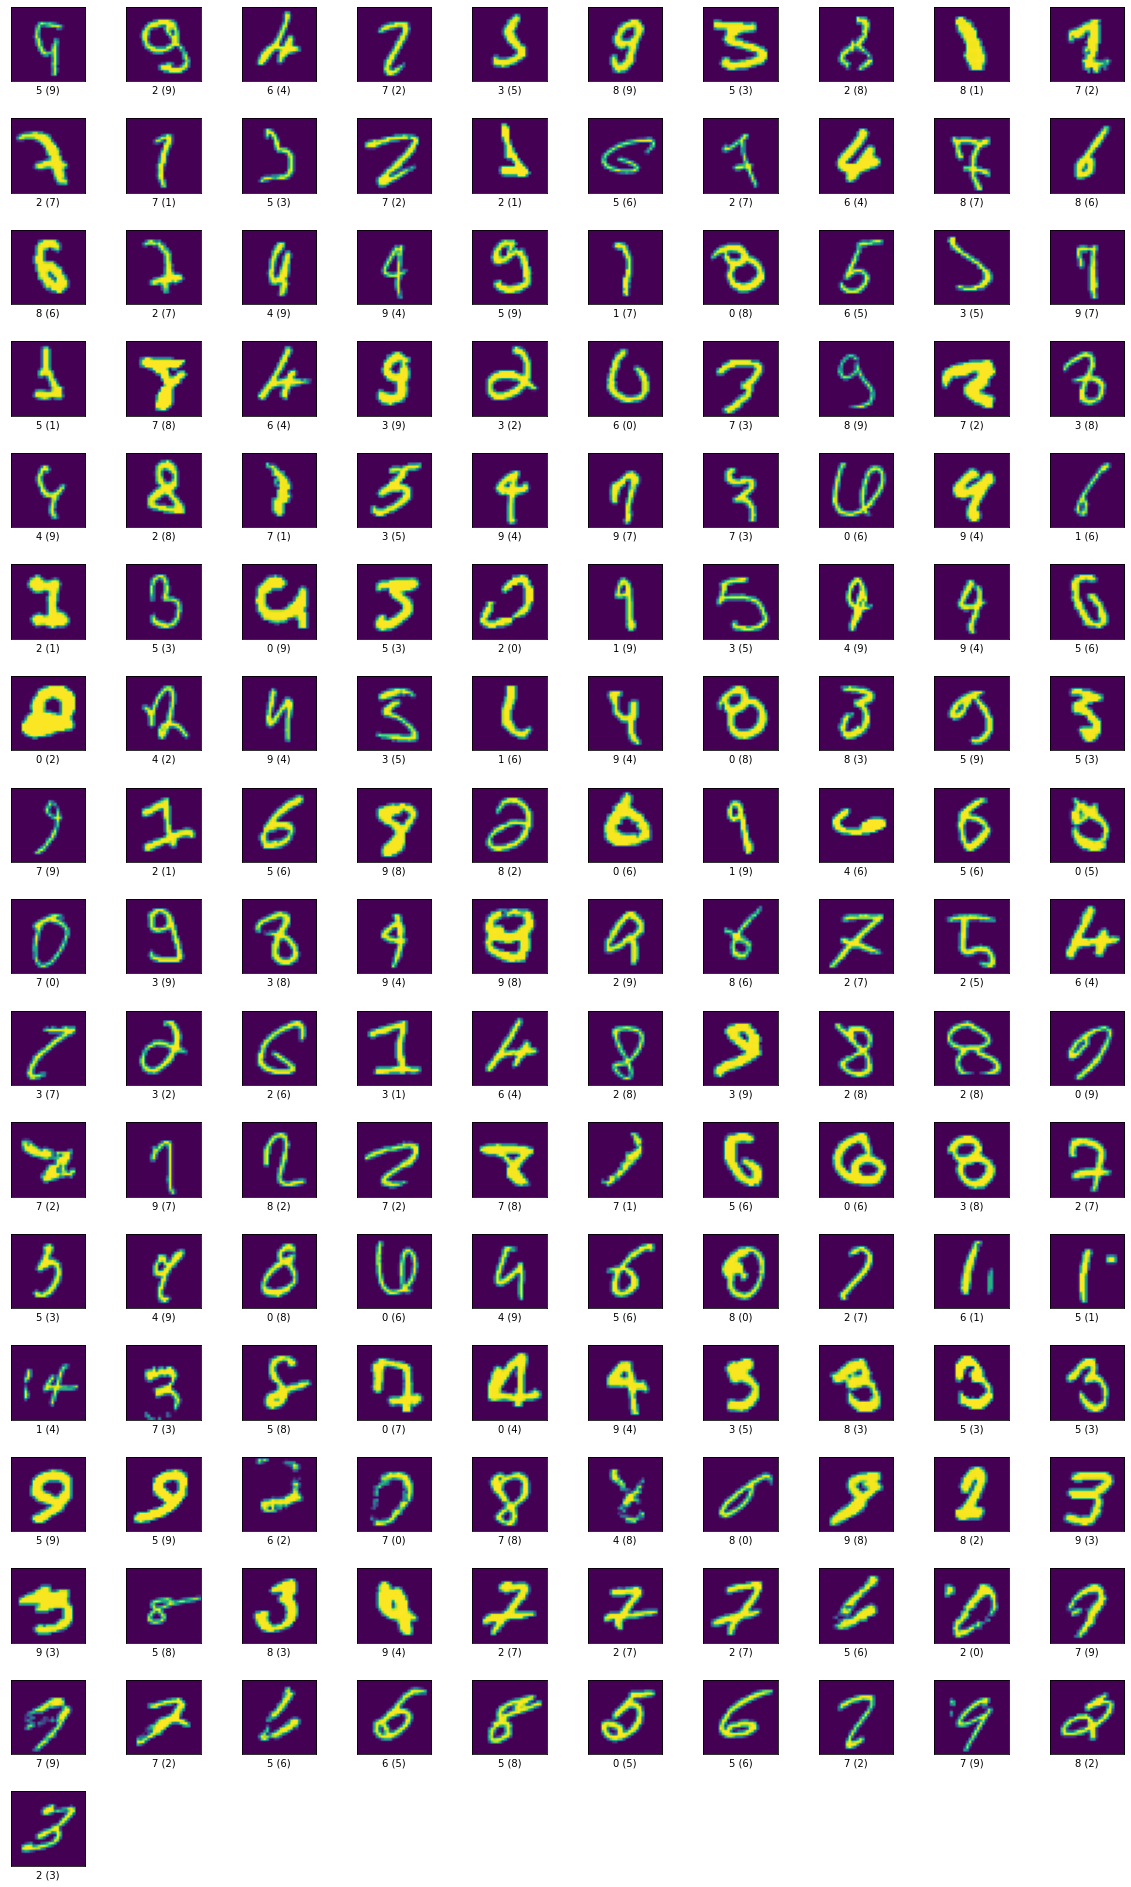

In [7]:
display_dataframe(missmatches, labels=labels.tolist(), cols=10)

## SHAP
The function plot_shap is using [shap library](https://shap-lrjball.readthedocs.io) and its [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) under the hood. It is an enhanced version of DeepLIFT algorithm.

### Test Dataset
The following plot show shap explanation for the first occurence of every number in the test dataset.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


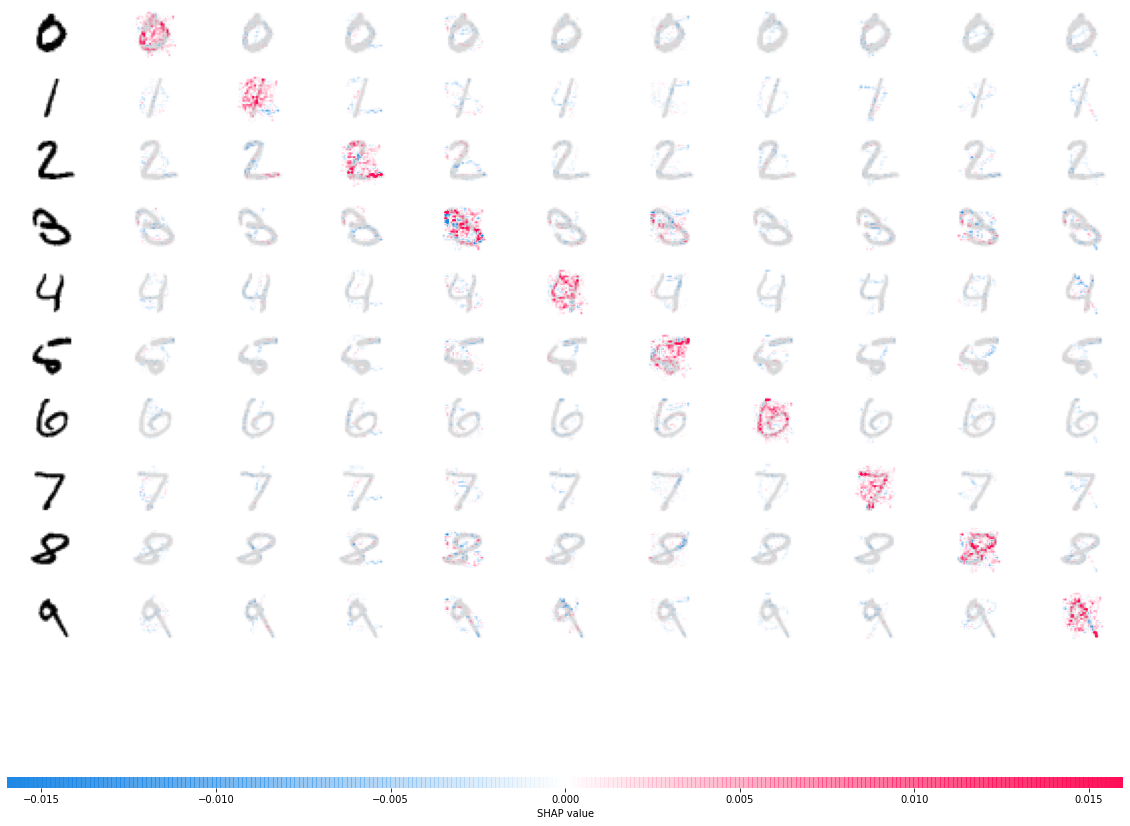

In [8]:
plot_shap(model, x_test[first_occurence(y_test)], file=shap_original)

### Test Dataset Misspredictions
I am even more interested how a shap plot of misspredicted digits might look like. Therefore out of the misspredictions I take every first digit.

In [11]:
first_missmatch_ids = first_occurence(y_test[comparison_missmatch.index])
missmatches_in_plot = comparison.iloc[first_missmatch_ids]
missmatches_in_plot.to_parquet(shap_original_label)
missmatches_in_plot

,actual,prediction
1621,0,6
619,1,8
321,2,7
449,3,5
247,4,6
340,5,3
1014,6,5
684,7,2
582,8,2
62,9,5


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


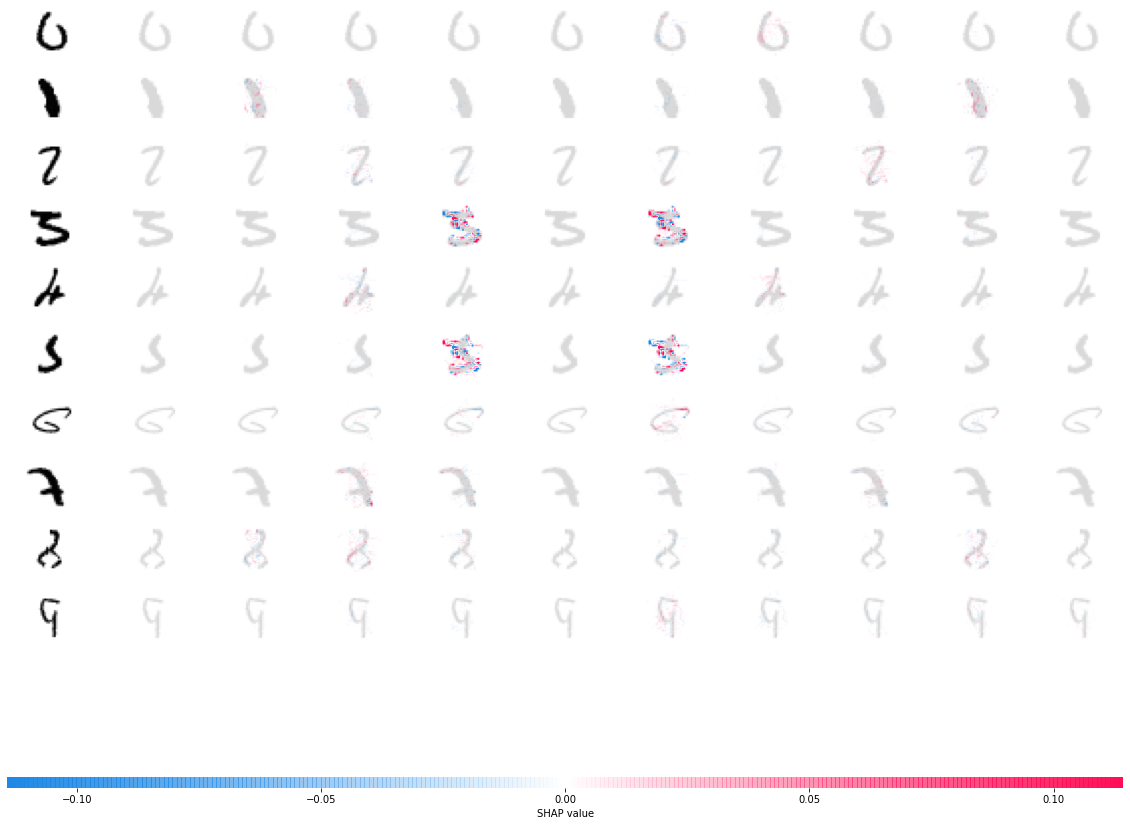

In [12]:
plot_shap(model, x_test[first_missmatch_ids], file=shap_original_missmatches)